https://github.com/qiskit-community/subgraph-isomorphism


In [1]:
!pip install "qiskit[visualization]" --quiet
!pip install qiskit-aer --quiet
!pip install qiskit_ibm_runtime

In [2]:
your_api_key = "Qg1qdTxfaf9jCeY_cZSPwamXCAeOhKMGxdnCCX1ug73G"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/35f051d9a857434d90fa642e973c7520:884336a7-237f-4cfe-af9f-e05bbaf092cf::"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)

In [3]:
service = QiskitRuntimeService()
service.saved_accounts()

{'default-ibm-quantum-platform': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'Qg1qdTxfaf9jCeY_cZSPwamXCAeOhKMGxdnCCX1ug73G',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/35f051d9a857434d90fa642e973c7520:884336a7-237f-4cfe-af9f-e05bbaf092cf::',
  'verify': True,
  'private_endpoint': False}}

In [4]:
service.backends()[0]


<IBMBackend('ibm_fez')>

service.backends

In [5]:
import networkx as nx
import random
import numpy as np
from qiskit.circuit.library import DiagonalGate
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator
from itertools import chain
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from itertools import product
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize


In [6]:
backend = service.backend('ibm_fez')
sim = AerSimulator()

In [7]:
S4_BLOCK_PARCOUNT = 5

def _expand_topology(topology, *, qreg: QuantumRegister) -> np.ndarray:
    if isinstance(topology, str):
        if topology in {"linear", "circular"}:
            v = np.arange(qreg.size - 1)
            v = np.stack([v, v + 1]).T
            if topology == "circular" and qreg.size > 2:
                v = np.concatenate([v, np.array([[qreg.size - 1, 0]])], axis=0)
            topology = v
    topology = np.asarray(topology)
    fun = np.vectorize(lambda i: qreg[i])
    return fun(topology)
def _hcph(phi: float, qc: QuantumCircuit, qubits):
    ctrl, target = qubits if isinstance(qubits, tuple) else (-1, qubits)
    qc.h(target)
    if ctrl >= 0:
        qc.cp(phi, ctrl, target)
    else:
        qc.p(phi, target)
    qc.h(target)
def _s4_block(params: np.ndarray) -> QuantumCircuit:
    params = np.asarray(params).flatten()
    assert params.shape == (S4_BLOCK_PARCOUNT,)
    qc = QuantumCircuit(QuantumRegister(name="q", size=2))
    _hcph(params[0], qc, 0)

    qc.h(1)
    qc.p(params[1], 1)
    qc.cp(params[2], 0, 1)
    qc.h(1)

    _hcph(params[3], qc, (1, 0))
    _hcph(params[4], qc, (0, 1))
    return qc
def s4_ansatz(topology, *, qreg, params=None):
    if isinstance(qreg, int):
        qreg = QuantumRegister(qreg)
    if isinstance(topology, str):
        if topology in {"linear", "circular"}:
            v = np.arange(qreg.size - 1)
            v = np.stack([v, v + 1]).T
            if topology == "circular" and qreg.size > 2:
                v = np.concatenate([v, np.array([[qreg.size - 1, 0]])], axis=0)
            topology = v
    topology = np.asarray(topology)
    fun = np.vectorize(lambda i: qreg[i])
    topology =  fun(topology)
    if params is None:
        num_edges = len(topology)
        vec = ParameterVector("θ", length=num_edges * S4_BLOCK_PARCOUNT)
        params = np.asarray(vec.params, dtype=object)
        params = params.reshape((num_edges, S4_BLOCK_PARCOUNT))  # ← proper 2D array of Parameters
    else:
        params = np.asarray(params, dtype=object)
        assert params.ndim == 2 and params.shape == (len(topology), S4_BLOCK_PARCOUNT)
    params = np.asarray(params)

    qc = QuantumCircuit(qreg)
    for v, q in zip(params, topology):
        qc.compose(_s4_block(v), qubits=q, inplace=True)

    qc_ = QuantumCircuit(qreg)
    qc_.compose(qc.to_gate(label="PermAnsatz"), inplace=True)
    return qc_, params
def _circ_qregs(n: int, *, as_qubits=False):
    m = (n - 1) // 2
    regs_config = zip((m, m, 1), ("i", "j", "a"))
    ret = tuple(QuantumRegister(sz, name=name) for sz, name in regs_config)
    return tuple(chain(*ret)) if as_qubits else ret
def _adj_flatten_repr(adj: np.ndarray, shape, name = "diagonal") -> QuantumCircuit:
    n = adj.shape[0]
    ideal_shape = np.ceil(np.log2(n))
    if shape > n:
        zeros = np.zeros((shape,shape), dtype = adj.dtype)
        zeros[:n, :n] = adj
        adj = zeros
    adj = adj.flatten()
    adj = np.concatenate([np.zeros_like(adj), adj])
    adj = np.exp(1j * adj * np.pi)
    diag_gate = DiagonalGate(adj)
    qc = QuantumCircuit(*_circ_qregs(diag_gate.num_qubits), name = name)
    qc = qc.compose(diag_gate,qubits=_circ_qregs(diag_gate.num_qubits, as_qubits=True))

    return qc
def _qc_block(qc, label=None):
    qc_ = QuantumCircuit(*qc.qregs, *qc.cregs)
    qc_.compose(qc.to_gate(label=label), inplace=True)
    return qc_
def observable(n: int) -> SparsePauliOp:
    """Return -((Z+I)/2)^{\\otimes n} as a SparsePauliOp."""
    coeff = -1.0 / (2 ** n)
    paulis = []
    coeffs = []
    for bits in product(('I','Z'), repeat=n):
        s = ''.join(bits)  # Qiskit's Pauli string uses qubit-0 as leftmost by default for some tools; check conventions
        paulis.append(s)
        coeffs.append(coeff)
    # SparsePauliOp.from_list expects list of (pauli_str, coeff)
    pauli_list = list(zip(paulis, coeffs))
    return SparsePauliOp.from_list(pauli_list)
def ansatz(adj1, adj2, *, topology="circular"):
  n = adj1.shape[0]
  padded_shape = int(2**int(np.ceil(np.log2(n))))
  diag1 = _adj_flatten_repr(adj1, padded_shape, 'diagonal graph')
  print("diag1 num qubits ", diag1.num_qubits)
  diag2 = _adj_flatten_repr(adj2, padded_shape, 'diagonal subgraph')
  print("diag2 num qubits ", diag1.num_qubits)

  qregs = _circ_qregs(diag1.num_qubits)
  print("qregs ", qregs)
  h_layer = QuantumCircuit(*qregs)
  print("hlayer ", h_layer.num_qubits)
  log_n = int(np.log2(n))
  for r in qregs[:2]:
      h_layer.h(r[:log_n])
  h_layer.h(qregs[2])

  perm_qc, params = s4_ansatz(topology, qreg=qregs[0])
  print('perm qc ', perm_qc.num_qubits)
  qc_block = QuantumCircuit(*diag1.qregs, *diag1.cregs)
  qc_block.compose(perm_qc.inverse().to_gate(label="PermAnsatzDg"), inplace=True, qubits = qregs[0])
  qc_block.compose(perm_qc.inverse().to_gate(label="PermAnsatzDg"), inplace=True, qubits = qregs[1])
  print('qc block', qc_block.num_qubits)
  diag1.compose(qc_block,front=True,inplace=True)
  diag1.compose(h_layer, front=True, inplace=True)
  diag1.compose(perm_qc, inplace=True, qubits=qregs[0])
  diag1.compose(perm_qc, inplace=True, qubits=qregs[1])
  diag1.compose(diag2, inplace=True)
  diag1.compose(h_layer, inplace=True)
  return diag1, params
def thetas_to_prob(x) -> np.ndarray:
    """Transform an array of angles into an array of probabilities.
    The probabilities are obtained by considering how close
    is each angle to an even or odd multiple of pi.
    """
    x = np.asarray(x) / np.pi
    x = np.abs(x)
    r = np.modf(x)
    r = r[0], r[1] % 2
    return np.abs(r[0] - r[1])
def sample_exact_thetas(v, *, n=1, seed=None):
    if isinstance(v, dict):
        dkeys = v.keys()
        v = np.array(list(v.values()))
    v = thetas_to_prob(v)
    rng = np.random.default_rng(seed)
    prob = rng.uniform(size=(n, len(v)))
    v = (prob < v) * np.pi
    if dkeys is not None:
        v = [dict(zip(dkeys, v1)) for v1 in v]
        assert len(v) == n
    return v

In [103]:
num_nodes_G = 6
num_nodes_H = 3
G = nx.erdos_renyi_graph(num_nodes_G, p=0.4)
G_adj = nx.to_numpy_array(G)
selected_nodes = random.sample(range(num_nodes_G), num_nodes_H)
H_adj = G_adj[np.ix_(selected_nodes, selected_nodes)]

[1, 3, 0]


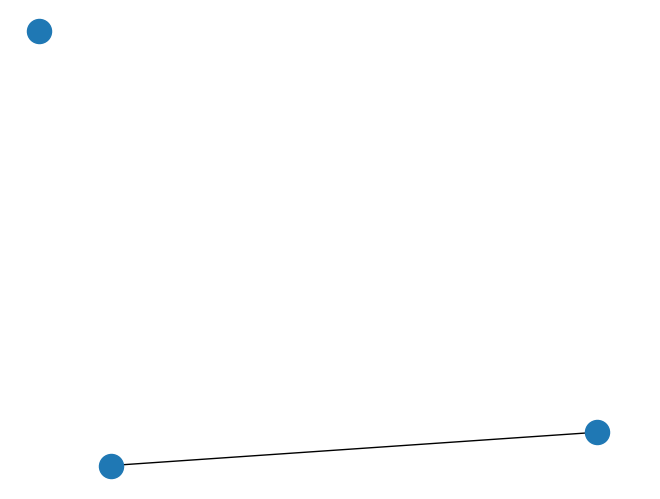

In [104]:
nx.draw(nx.from_numpy_array(H_adj))

diag1 num qubits  7
diag2 num qubits  7
qregs  (QuantumRegister(3, 'i'), QuantumRegister(3, 'j'), QuantumRegister(1, 'a'))
hlayer  7
perm qc  3
qc block 7


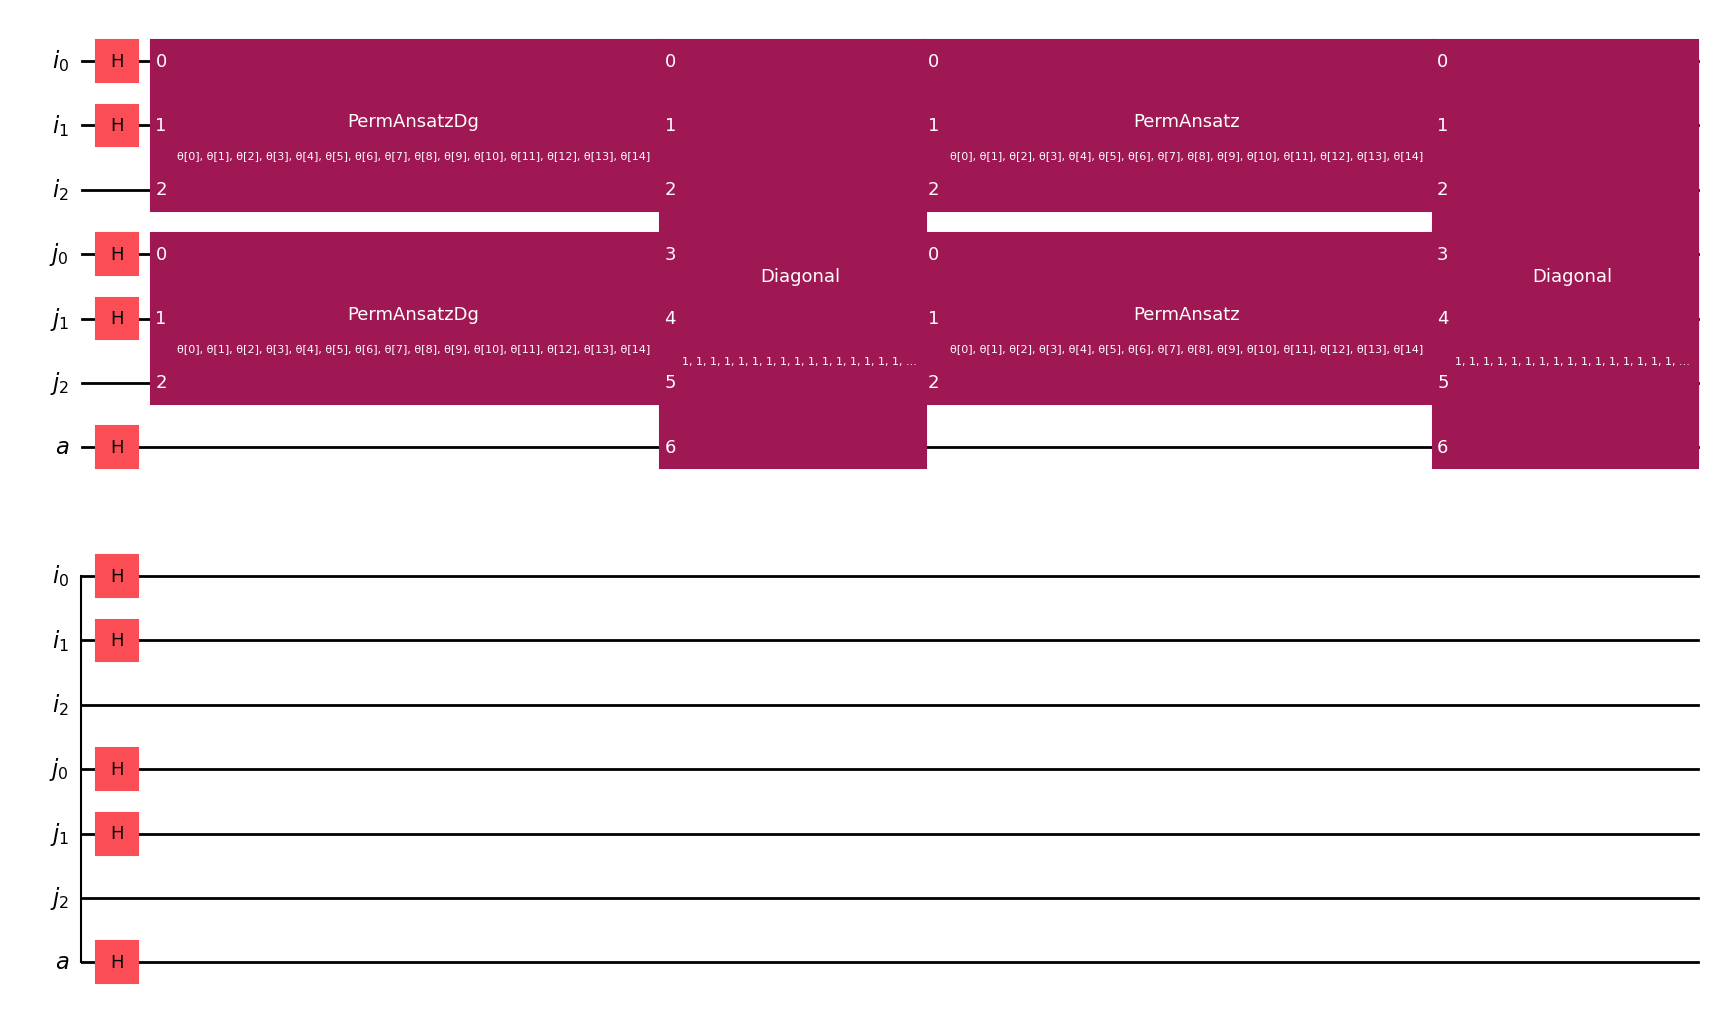

In [9]:
qc, params = ansatz(G_adj, H_adj)
qc.draw('mpl')

In [10]:
qc.count_ops()

OrderedDict([('h', 10),
             ('circuit-53_dg', 2),
             ('diagonal', 2),
             ('circuit-49', 2)])

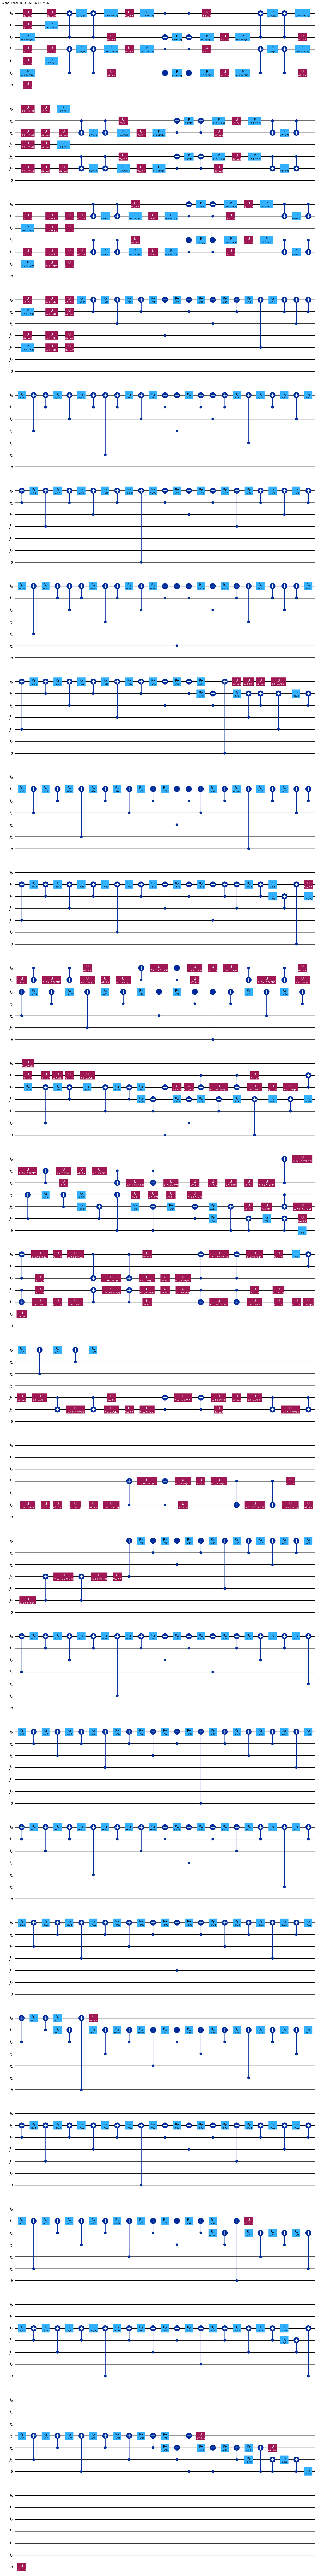

In [11]:
qc.decompose().decompose().decompose().draw('mpl')

In [12]:
qc.decompose().decompose().decompose().count_ops()

OrderedDict([('cx', 324), ('rz', 228), ('u', 184), ('p', 54)])

In [13]:
qc.decompose().decompose().decompose().depth()

571

In [14]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

In [15]:
qc_isa.depth()

1655

In [16]:
qc_isa.draw('mpl', fold = 120, )

In [17]:
hamiltonian = observable(qc.num_qubits)
hamiltonian_isa = hamiltonian.apply_layout(layout=qc_isa.layout)


In [107]:
estimator = Estimator(mode=sim)

In [27]:
estimator.options.default_shots = 20000

In [28]:
# assuming hamiltonian_isa is SparsePauliOp
Ham = hamiltonian.to_matrix()  # dense matrix
eigvals, _ = np.linalg.eigh(Ham)
exact_ground_energy = np.min(eigvals)
print("Exact ground energy:", exact_ground_energy)

Exact ground energy: -1.0


In [29]:
rng = np.random.default_rng(seed=42)
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

initial_point = (rng.uniform(size=len(qc.parameters)) - 1/2) * 2 * np.pi
res = minimize(
        cost_func,
        initial_point,
        args=(qc_isa, hamiltonian_isa, estimator),
        method="Nelder-Mead",
        options={"maxiter": 150, },
    )

Iters. done: 1 [Current cost: -0.41816000000000014]
Iters. done: 2 [Current cost: -0.42288]
Iters. done: 3 [Current cost: -0.41948]
Iters. done: 4 [Current cost: -0.41928000000000004]
Iters. done: 5 [Current cost: -0.41746000000000005]
Iters. done: 6 [Current cost: -0.41977999999999993]
Iters. done: 7 [Current cost: -0.4286199999999999]
Iters. done: 8 [Current cost: -0.41716]
Iters. done: 9 [Current cost: -0.41856000000000004]
Iters. done: 10 [Current cost: -0.4191000000000001]
Iters. done: 11 [Current cost: -0.41734000000000016]
Iters. done: 12 [Current cost: -0.4127599999999999]
Iters. done: 13 [Current cost: -0.4202200000000001]
Iters. done: 14 [Current cost: -0.42222]
Iters. done: 15 [Current cost: -0.42582000000000003]
Iters. done: 16 [Current cost: -0.4200399999999999]
Iters. done: 17 [Current cost: -0.4238199999999999]
Iters. done: 18 [Current cost: -0.4218800000000002]
Iters. done: 19 [Current cost: -0.42647999999999997]
Iters. done: 20 [Current cost: -0.42509999999999987]
Iter

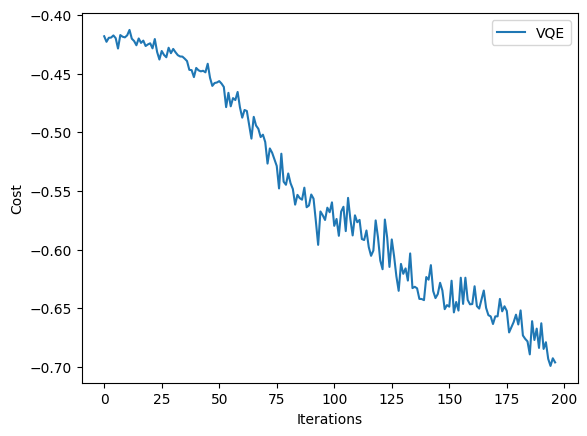

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(
    range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="VQE"
)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.legend()
plt.draw()

In [33]:
final_params = res.x                     # the optimized parameters
final_energy = res.fun                   # should be close to -1.0 for success

print(f"Final energy: {final_energy:.6f}")
print(f"Success probability ≈ { -final_energy :.4f}")   # because <ψ|H|ψ> = -p_success

Final energy: -0.699080
Success probability ≈ 0.6991


In [95]:
# ==================================================================
# FINAL WORKING MAPPING EXTRACTION – QISKIT 2.x (November 2025)
# ==================================================================
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator
import qiskit
import numpy as np

def extract_subgraph_mapping_2x(qc, final_params, num_nodes_G, num_nodes_H, threshold=0.85, size = num_nodes_H):
    """
    Works 100% with your current diagonal-encoding ansatz in Qiskit 2.x.
    Returns the induced subgraph node mapping or None.
    """
    bound_qc = qc.assign_parameters(final_params)

    # Use StatevectorEstimator + a separate StatevectorSampler for the wavefunction
    estimator = StatevectorEstimator()
    sampler = qiskit.primitives.StatevectorSampler()

    # 1. Get success probability exactly
    success_obs = SparsePauliOp("Z" * bound_qc.num_qubits)  # <1...1|ψ> = (-1)^n <Z...Z|ψ>
    sign = (-1) ** bound_qc.num_qubits
    pub_energy = (bound_qc, success_obs)
    energy_result = estimator.run([pub_energy]).result()[0]
    overlap_real = energy_result.data.evs  # this is <Z...Z>
    print(overlap_real)
    prob_success = (1 + sign * overlap_real) / 2   # converts to |<1...1|ψ>|²

    print(f"Exact success probability: {prob_success:.6f}")


    # 2. Get the actual statevector to read out the register
    bound_qc.measure_all()
    pub_sample = (bound_qc,)
    sample_result = sampler.run([pub_sample], shots=1024).result()[0].data.meas.get_counts()
    sorted_results = {k: v for k, v in sorted(sample_result.items(), key=lambda item: item[1], reverse=True)}


    new_dict = {}
    nodes = []
    for bitstring, count in sorted_results.items():
        if len([int(x) for x in bitstring[:-1] if x == '1'])  == size:
            new_dict[bitstring[:-1]] = new_dict.get(bitstring[:-1], 0) + count

    selected_nodes = []
    for k in new_dict.keys():
        for i, bit in enumerate(k):
            if bit == '1':
                selected_nodes.append(i)
        break

    return selected_nodes



# ==================================================================
# RUN IMMEDIATELY AFTER YOUR minimize
# ==================================================================
mapping = extract_subgraph_mapping_2x(qc, cost_history_dict["prev_vector"], num_nodes_G, num_nodes_H)



0.6644869757855223
Exact success probability: 0.167757


In [96]:
mapping

[0, 2, 3]

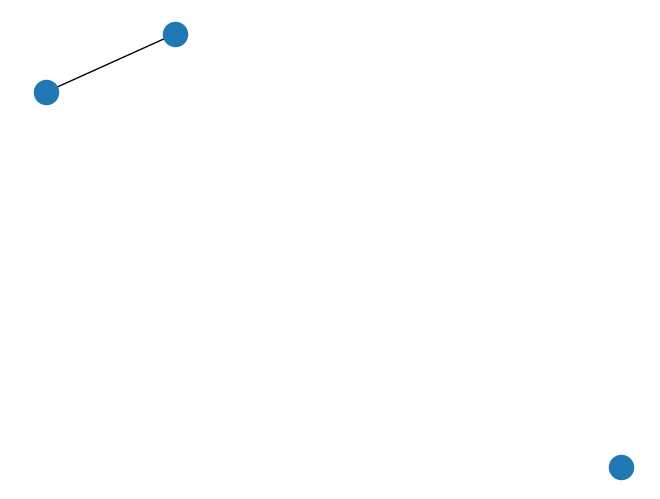

In [105]:
sel = [0,2,3]
nx.draw(nx.from_numpy_array(G_adj[np.ix_(sel, sel)]))

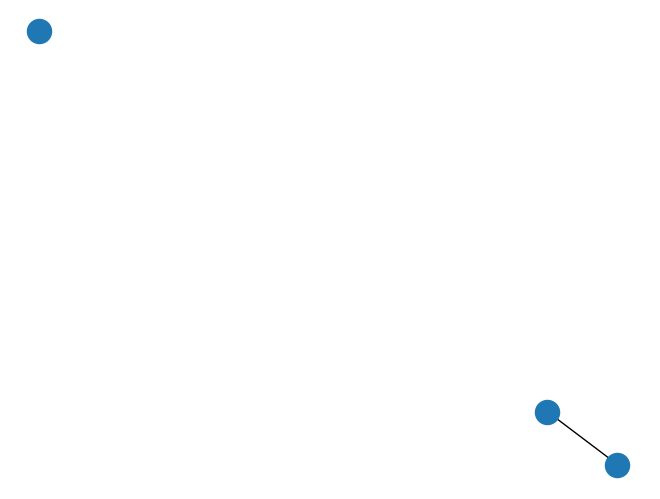

In [106]:
nx.draw(nx.from_numpy_array(H_adj))